#***ADECUACIÓN DE BASE DE DATOS***

---



---


In [ ]:
!pip install chart_studio missingno

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.0 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=4060c822a7da996d514578837c41a11cf9a25b0c555fb74197fab6576a0a7bb6
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [ ]:
import numpy as np
import pandas as pd 

from sklearn import preprocessing # Data Scaling
from sklearn import decomposition #PCA
from sklearn.cluster import KMeans

import chart_studio
from chart_studio import plotly as py
import plotly.graph_objs as go
import chart_studio.tools as tls
import plotly.express as px

In [ ]:
#Login Chart-Studio Plotly
username = 'gabriel.fernandez'
api_key = 'GuaZQhD2Q8wKlLhiomcn'

chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Agencia/pastas_panif/dbs/1905.csv')

In [ ]:
df = df[['year','reporter', 'reporter_iso','commodity_code','trade_value_usd','partner',
       'partner_iso']]
df['trade_value_usd'] = df['trade_value_usd'] / 1000000       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df1['commodity_code'].astype('int', errors='ignore')
ncm = [71320.0] 
    
# selecting rows based on condition 
df1.loc[df1['commodity_code'].isin(ncm)]

In [ ]:
UE = ["USA","DEU","AUT","BEL","BGR","CYP","HRV","DNK","SVK","SVN","ESP","EST",
      "FIN","FRA","GRC","HUN","IRL","ITA","LVA","LTU","LUX","MLT","MCO","NLD",
      "POL","PRT","GBR","CZE","ROU","SMR","SWE"]

In [ ]:
result = []
for value in df['partner_iso']:
  if value == "ARG":
    result.append("ARG")
  elif value == "CHN":
    result.append("CHN")
  elif value in UE:
    result.append("UE")
  else:
    result.append("Resto")
   
df["procedencia"] = result

In [ ]:
df1 = df.copy()

In [ ]:
# i) Creo df de totales y ii) desagregago por partners (totales y media)
df_salud_proc = df.sort_values(by=['reporter_iso'], ascending = [True]).groupby(['reporter_iso', 'reporter']).agg(total =  ('trade_value_usd', sum),
                                                                                                    media_value = ('trade_value_usd', 'mean'),
                                                                                                    first = ('trade_value_usd', 'first'),
                                                                                                    last =('trade_value_usd', 'last'),
                                                                                                    last_year = ('year', 'last'))

df_salud_proc2 = df.sort_values(by=['reporter_iso'], ascending = [True]).groupby(['reporter_iso','procedencia']).agg(total =  ('trade_value_usd', sum),
                                                                                                                   media =('trade_value_usd', 'mean'),
                                                                                                                   first = ('trade_value_usd', 'first'),
                                                                                                                   last =('trade_value_usd', 'last'))

df_salud_proc2 = df_salud_proc2.unstack()

df_salud_proc2.columns = ['ARG_sum','UE_sum','CHN_sum','Resto_sum',
                          'ARG_media','UE_media','CHN_media','Resto_media',
                          'ARG_first','UE_first','CHN_first','Resto_first',
                          'ARG_last','UE_last','CHN_last','Resto_last']
# Merge i) y ii)
df_salud_proc3 = pd.merge(df_salud_proc, df_salud_proc2, left_index=True, right_index=True)

#Calculo participacion de cada partner por iso_pais
df_salud_proc3['ARG_part'] = (df_salud_proc3['ARG_sum'] / df_salud_proc3['total'])*100  
df_salud_proc3['UE_part'] = (df_salud_proc3['UE_sum'] / df_salud_proc3['total'])*100  
df_salud_proc3['CHN_part'] = (df_salud_proc3['CHN_sum'] / df_salud_proc3['total'])*100  
df_salud_proc3['Resto_part'] = (df_salud_proc3['Resto_sum'] / df_salud_proc3['total'])*100  

#Calculo variaciones de importaciones para el iso_pais, mediana, y si el pais está encima o debajo de la mediana
df_salud_proc3['var_impo'] = ((df_salud_proc3['last'] / df_salud_proc['first'])-1)*100

mediana = df_salud_proc3['media_value'].median()
df_salud_proc3['mayor_median'] = np.where(
    df_salud_proc['media_value'] < mediana, "NO", "SI") 

In [ ]:
import missingno as msno

In [ ]:
df_salud_proc3.isna().sum()

total            0
media_value      0
first            0
last             0
last_year        0
ARG_sum         76
UE_sum           2
CHN_sum          0
Resto_sum        0
ARG_media       76
UE_media         2
CHN_media        0
Resto_media      0
ARG_first       76
UE_first         2
CHN_first        0
Resto_first      0
ARG_last        76
UE_last          2
CHN_last         0
Resto_last       0
ARG_part        76
UE_part          2
CHN_part         0
Resto_part       0
var_impo         0
mayor_median     0
dtype: int64

In [ ]:
df_salud_proc3.shape

(169, 27)

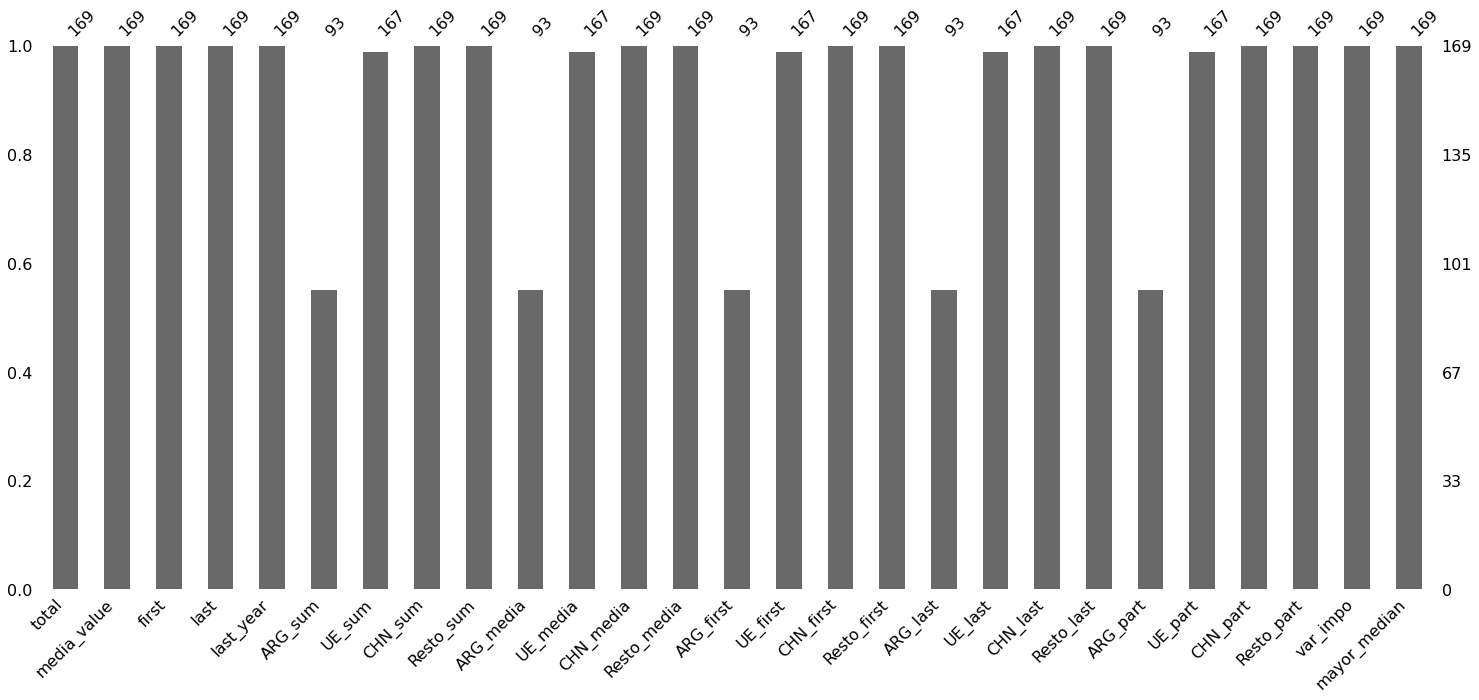

In [ ]:
msno.bar(df_salud_proc3)

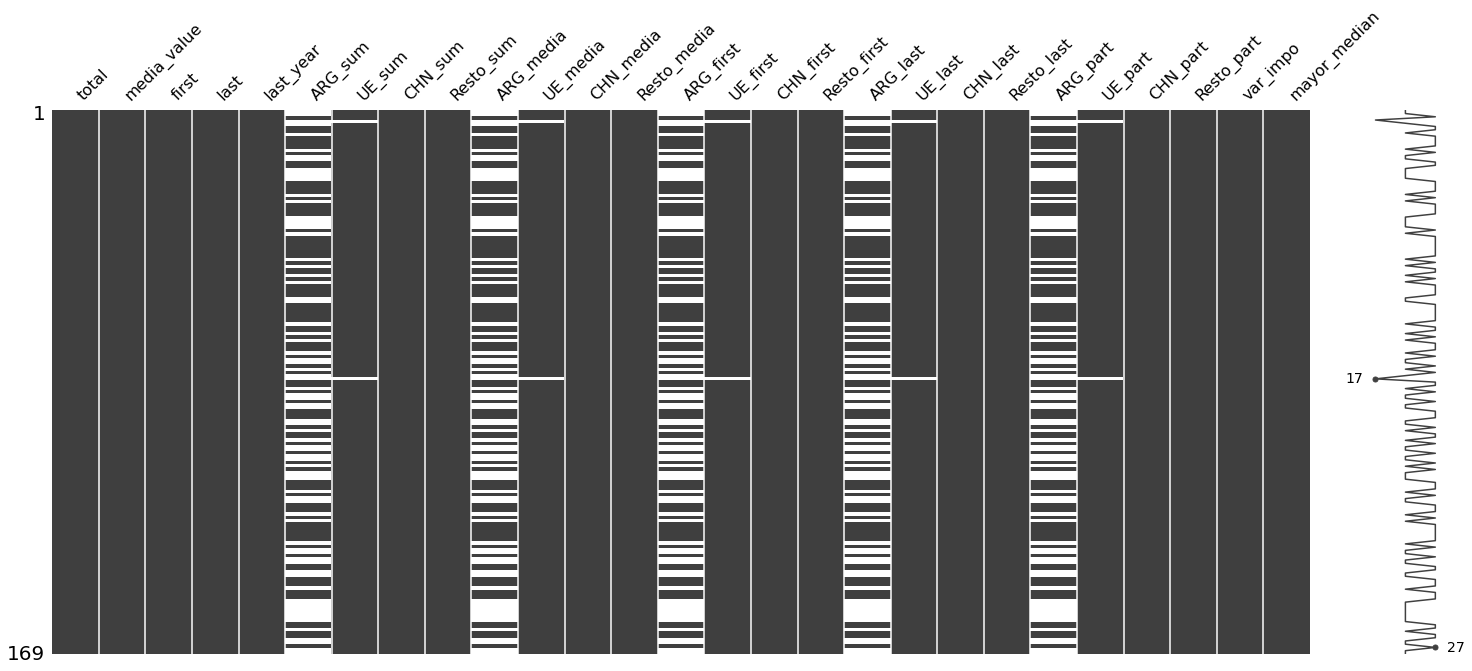

In [ ]:
msno.matrix(df_salud_proc3)
#msno.dendrogram(df)
#msno.heatmap(df)

In [ ]:
df_salud_proc3['ARG_part'] = df_salud_proc3['ARG_part'].fillna(0).astype(int)

In [ ]:
df_salud_proc3.head()

,,total,media_value,first,last,last_year,ARG_sum,UE_sum,CHN_sum,Resto_sum,ARG_media,...,ARG_last,UE_last,CHN_last,Resto_last,ARG_part,UE_part,CHN_part,Resto_part,var_impo,mayor_median
reporter_iso,reporter,,,,,,,,,,,,,,,,,,,,,
ABW,Aruba,132.410081,3.484476,8.285506,0.079643,2021,NaN,0.071261,76.022510,56.316310,NaN,...,NaN,0.031737,0.000240,0.079643,0,0.053818,57.414443,42.531739,-99.038767,SI
AFG,Afghanistan,50.827121,1.104937,0.004835,0.191363,2019,NaN,0.006083,50.700639,0.120399,NaN,...,NaN,0.000520,0.191363,0.006440,0,0.011968,99.751153,0.236879,3857.869700,NO
AGO,Angola,318.805836,2.433632,0.567049,0.087486,2019,5.371387,2.633460,261.341734,49.459255,1.790462,...,1.890618,1.041570,0.087486,0.192618,1,0.826039,81.975204,15.513911,-84.571704,SI
ALB,Albania,327.867879,5.374883,0.031104,9.299434,2017,NaN,NaN,222.378925,105.488954,NaN,...,NaN,NaN,1.519637,9.299434,0,NaN,67.825774,32.174226,29797.871656,SI
AND,Andorra,73.716031,1.602522,0.014767,0.000024,2017,NaN,0.000050,36.935098,36.780883,NaN,...,NaN,0.000050,0.000394,0.000024,0,0.000068,50.104567,49.895365,-99.837475,NO


In [ ]:
impo_global = df_salud_proc3[['total', 'media_value', 'ARG_part', 'UE_part', 'CHN_part', 'Resto_part', 'last_year']]
impo_global = impo_global.round(2)

In [ ]:
impo_global = impo_global.reset_index()

In [ ]:
filename = '/content/drive/My Drive/Agencia/equipamiento_medico/cod_paises.csv' 
f = open(filename, "r")
cod_paises = pd.read_csv(filename, sep=',', encoding= 'unicode_escape')

In [ ]:
cod_paises.columns = ['reporter_iso','continente','reporter','zona']

In [ ]:
#Merge entre base con el listado de codigos de paises
df_salud_proced = pd.merge(df_salud_proc3, cod_paises, on = 'reporter_iso')

In [ ]:
#Fillna para conservar la variable ARG_part y no excluir tantos paises en el PCA
df_salud_proced[['ARG_sum','ARG_media','ARG_first','ARG_part','ARG_last']] = df_salud_proced[['ARG_sum','ARG_media','ARG_first','ARG_part','ARG_last']].fillna(0).astype(int)

In [ ]:
df_salud_proced.shape

(168, 31)

In [ ]:
#Guardo como CSV
df_salud_proced.to_csv("/content/drive/MyDrive/Agencia/pastas_panif/dbs/df_salud_proced.csv", index=False)

In [ ]:
filename = '/content/drive/My Drive/Agencia/pastas_panif/dbs/food_price_inflation.csv' 
f = open(filename, "r")
infla = pd.read_csv(filename)#, sep=',', encoding= 'unicode_escape')

In [ ]:
infla = infla[['Area', 'Year', 'Item', 'Months', 'Value']]
infla.columns = ['reporter', 'Year', 'Item', 'Months', 'Value']

In [ ]:
inflation = infla.groupby(['reporter', 'Year']).agg(total =  ('Value', sum))

In [ ]:
infla_mean = inflation.groupby(['reporter']).agg(infla_mean =  ('total', 'mean')).reset_index()

In [ ]:
infla_mean.head()

,reporter,infla_mean
0,?land Islands,12.617571
1,Afghanistan,50.737511
2,Albania,38.361649
3,Algeria,34.726735
4,Andorra,22.769388


#**CLUSTERIZACIÓN**

---



---

In [ ]:
#Import economic, demografic and health spending (public & private) (World Bank Data Base)
filename = '/content/drive/My Drive/Agencia/pastas_panif/dbs/data_base_DECS.xlsx' 
f = open(filename, "r")
data_gral = pd.read_excel(filename)#, sep=',', encoding= 'unicode_escape')

In [ ]:
data_gral.columns

Index(['Country Name', 'Country Code', 'D1', 'D3', 'D7', 'E3', 'E5', 'C2',
       'C4', 'C5', 'S3', 'S5', 'S7', 'G1', 'G7', 'G8'],
      dtype='object')

In [ ]:
#Impute NaN with zeros
data_gral['C2'] = data_gral['C2'].replace(0, np.nan)
data_gral['S7'] = data_gral['S7'].fillna(0).astype(int)

In [ ]:
#Drop C5 - Correlation
data_gral = data_gral.drop('C5', axis = 1)

In [ ]:
#Rename columns
data_gral.columns = ['reporter', 'reporter_iso', 'D1', 'D3', 'D7', 'E3', 'E5', 'C2',
       'C4', 'S3', 'S5', 'S7', 'G1', 'G7', 'G8']

In [ ]:
#Select columns from imports dataframe
df_salud_sub = df_salud_proced[['media_value', 'ARG_part', 'UE_part', 'CHN_part','reporter_iso']]

#Merge
df_cluster = pd.merge(data_gral, df_salud_sub, on = 'reporter_iso', how = 'inner')

In [ ]:
df_cluster_vf = pd.merge(df_cluster, infla_mean, on = 'reporter', how = 'inner')

In [ ]:
df_cluster_vf = df_cluster_vf.drop(['D3','S3','S5','S7','G1','G7','G8'], axis = 1)

In [ ]:
#Drop NaN (sine qua non condition to apply PCA)
data_pc = df_cluster_vf.dropna()
data_pc = data_pc.set_index('reporter_iso')
#Subset PCA
data_pc_slice = data_pc.iloc[:,1:12]
columns_slice = data_pc_slice.columns
data_pc_slice = data_pc_slice.astype(float)
data_pc_slice.shape

(132, 11)

In [ ]:
#Preprossecing data
#data_x = preprocessing.scale(data_pc_slice)
#data_x = pd.DataFrame(data_x, columns = columns_slice)

data_x = preprocessing.StandardScaler().fit_transform(data_pc_slice)
data_x = pd.DataFrame(data_x, columns = columns_slice)

In [ ]:
#PRINCIPAL COMPONENTS ANALYSIS
pca = decomposition.PCA(n_components=5)
pca.fit(data_x)
comp = pca.transform(data_x)
comp_df = pd.DataFrame(comp, columns=['PC1', 'PC2', 'PC3','PC4', 'PC5'])

In [ ]:
#Dataframa WB variables, Imports and PCs
df_slice_comp = pd.merge(data_x, comp_df, left_index=True, right_index=True)

In [ ]:
#KMEANS CLUSTERING
kmean = KMeans(n_clusters = 4, max_iter = 10000, n_init = 50)
kmean.fit(comp)

KMeans(max_iter=10000, n_clusters=4, n_init=50)

In [ ]:
#Cluster identification
#kMEANS labels to dataframe
clusters = kmean.labels_
clusters = pd.DataFrame(clusters, columns = ['cluster'])

#iso codes 
data_pc = data_pc_slice.reset_index() 

#Unir iso_pais, con df_slice_comp y cluster
df_vf = pd.merge(data_pc, comp_df, left_index=True, right_index=True)
df_vf = pd.merge(df_vf, clusters, left_index=True, right_index=True)

#Select columns
features = df_vf.columns[1:-6]

In [ ]:
features

Index(['D1', 'D7', 'E3', 'E5', 'C2', 'C4', 'media_value', 'ARG_part',
       'UE_part', 'CHN_part', 'infla_mean'],
      dtype='object')

In [ ]:
#Loadings matrix: correlation matrix
loadings_matrix = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2','PC3','PC4', 'PC5'], index=features)
loadings_matrix = loadings_matrix.reset_index()
loadings_matrix.columns = ['Referencia', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5'] 
#loadings_matrix = loadings_matrix.astype(str)

#Variables description
variables = {
    'Referencia': ['D1','D7','E3','E5','C2','C4','media_value','ARG_part','UE_part', 'CHN_part', 'infla_mean'],
    'Descripción': ['Producción promedio anual de harina (tn.)','Poblacion Total', 
                    'PIB per cápita (US$ a precios actuales)', 'Crecimiento del PIB (% anual)',
                    'Índice de facilidad para hacer negocios', 'Importaciones de bienes y servicios (% del PIB)', 'Valor promedio de importaciones',
                    'Participación argentina en importaciones', 'Participación UE en importaciones', 'Participación china en importaciones', 'Inflación alimentos promedio'
                    ]
}

variables = pd.DataFrame(variables)

#Merge loadings and variables descriptions
loadings_matrix_detalle = pd.merge(loadings_matrix, variables, on = 'Referencia')

#***PLOTS***

---



---

In [ ]:
df_vf = pd.merge(df_vf, cod_paises, on = 'reporter_iso', how = 'inner')

In [ ]:
df_vf.iloc[:, 1:16] = df_vf.iloc[:, 1:16].round(2) # Remember that Python does not slice inclusive of the ending index.

In [ ]:
df_vf.reporter = df_vf.reporter.replace('Reino Unido de Gran Bretaña e Irlanda del Norte', 'Reino Unido')

In [ ]:
# PCA and Clusters Scatter Plot


fig = px.scatter(df_vf, x=df_vf['PC1'], y=df_vf['PC2'], color=df_vf['cluster'],hover_data = ['reporter_iso', 'reporter','media_value', 'ARG_part', 'UE_part','CHN_part'], color_discrete_sequence=["green", "blue", "yellow", "magenta", "black"],
                 labels={'PC1': 'Componente Principal #1', 'PC2':'Componente Principal #2'})

#py.iplot(fig)
fig.show()

In [ ]:
df_comp = df_vf[['PC1', 'PC2', 'PC3', 'PC4', 'PC5','reporter', 'cluster']]

In [ ]:
df_vf.columns

Index(['reporter_iso', 'D1', 'D7', 'E3', 'E5', 'C2', 'C4', 'media_value',
       'ARG_part', 'UE_part', 'CHN_part', 'infla_mean', 'PC1', 'PC2', 'PC3',
       'PC4', 'PC5', 'cluster', 'continente', 'reporter', 'zona'],
      dtype='object')

In [ ]:
# Top 20 reporters. Anual Mean 2017-2021
df = df_vf
sd = df.nlargest(20,'media_value')
fd = sd.sort_values(by='media_value', ascending = True)

fig = px.bar(fd, x="media_value", y="reporter", orientation='h',
             hover_data=['reporter_iso','media_value', 'ARG_part', 'UE_part','CHN_part'],
             height=600,
             title='Principales importadores a nivel global: top 20 importadores. Promedio anual 2016-2020',
             labels={'media_value': 'Importaciones (millones USD)', 'reporter':'País'})
fig.show()

In [ ]:
#LATAM imports. Anual Mean 2016-2020 

latam = ['ARG','ABW','BHS','BRB','BLZ','BMU','BOL','BRA','CHL','COL','CRI','CUB','ECU','SLV','GTM',
         'GUF','GUY','HTI','HND','FLK','JAM','MEX','NIC','PAN','PRY','PER','PRI','DOM','SUR','TTO',
         'URY','VEN']

df = df_salud_proced.loc[df_salud_proced['reporter_iso'].isin(latam)]
sd = df.nlargest(20,'media_value')
fd = sd.sort_values(by='media_value', ascending = True)

fig = px.bar(fd, x="media_value", y="reporter", orientation='h',
             hover_data=['reporter_iso','media_value', 'ARG_part', 'UE_part','CHN_part'],
             height=600,
             title='Importaciones de Latinoamérica. Promedio anual 2016-2020',
             labels={'media_value': 'Importaciones (millones USD)', 'reporter':'País'})


#py.iplot(fig)
fig.show()

In [ ]:
#Argentina imports. Anual Mean 2016-2020 

# SLICING & GROUPING
imp_arg = df1[df1['partner_iso'] == 'ARG']
imp_arg = imp_arg.groupby(['reporter']).agg(total =  ('trade_value_usd', sum),
                                                          media_value =('trade_value_usd', 'mean'),
                                                          first = ('trade_value_usd', 'first'),last =('trade_value_usd', 'last'), last_year = ('year','last'))
imp_arg = imp_arg.reset_index()

imp_arg.reporter = imp_arg.reporter.replace('Bolivia (Plurinational State of)', 'Bolivia')

df = imp_arg
sd = df.nlargest(15,'media_value')
fd = sd.sort_values(by='media_value', ascending = True)

fig = px.bar(fd, x="media_value", y="reporter", orientation='h',
             hover_data=['reporter','media_value', 'first', 'last','last_year'],
             height=600,
             title='A qué países le exporta Argentina? Top 15 importadores. Promedio anual 2016-2020',
             labels={'media_value': 'Importaciones (millones USD)', 'reporter':'País'})

#py.iplot(fig)
fig.show()

In [ ]:
#Loadings matrix to Table
df = loadings_matrix
df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']] = df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].round(3) 

fig = go.Figure(data=[go.Table(
    columnorder = [1,2,3,4,5,6],
    columnwidth = [110, 80, 80, 80, 80, 80],
    header=dict(values=list(df.columns),
                fill_color='rgba(92,140,164)',
                align='center'),
    cells=dict(values=[df.Referencia, df.PC1, df.PC2, df.PC3, df.PC4, df.PC5],
               fill_color='rgba(196,196,196)',
               align='center'))
])
py.iplot(fig)
#fig.show()

In [ ]:
#Variables description to Table
df = variables 
fig = go.Figure(data=[go.Table(
    columnorder = [1,2],
    columnwidth = [80, 400],
    header=dict(values=list(df.columns),
                fill_color='rgba(92,140,164)',
                align='center'),
    cells=dict(values=[df.Referencia, df.Descripción],
               fill_color='rgba(196,196,196)',
               align='center'))
])
#py.iplot(fig)
fig.show()

In [ ]:
df2 = pd.merge(impo_global, cod_paises, on = 'reporter_iso', how = 'inner')
df2.reporter_x = df2.reporter_x.replace('Reino Unido de Gran Bretaña e Irlanda del Norte', 'Reino Unido')

In [ ]:
#df2 = df2.set_index('index')
#df2 = df2[['reporter_x', 'total', 'media_value', 'ARG_part', 'UE_part','CHN_part', 'Resto_part', 'last_year']]
df2=df2.rename(columns = {'total':'total (Mill.)', 'reporter_x':'reporter'})


In [ ]:
#Imports general data

fig = go.Figure(data=[go.Table(
    columnorder = [1,2,3,4,5,6,7,8],
    columnwidth = [110, 80, 80, 80, 80, 80, 80],
    header=dict(values=list(df2.columns),
                fill_color='rgba(92,140,164)',
                align='center'),
    cells=dict(values= [df2.reporter, df2['total (Mill.)'], df2.media_value, df2.ARG_part, df2.UE_part, df2.CHN_part, df2.Resto_part, df2.last_year],
               fill_color='rgba(196,196,196)',
               align='center'))
])
py.iplot(fig)
#fig.show()

In [ ]:
# RANKING PC1
df = df_vf
sd = df.nlargest(20,'PC1')
fd = sd.sort_values(by='PC1', ascending = True)

fig = px.bar(fd, x="PC1", y="reporter", orientation='h',
             hover_data=['reporter_iso','media_value', 'ARG_part', 'UE_part','CHN_part'],
             height=600,
             title='Top 20 Ranking de países según PC1',
             labels={'PC1': 'Componente Principal #1', 'reporter':'País'})

#py.iplot(fig)
fig.show()

In [ ]:
# Cluster #1 imports. Annual Mean 2016-2020
df = df_vf.loc[df_vf['cluster'].isin([0])]
sd = df.nlargest(20,'media_value')
fd = sd.sort_values(by='media_value', ascending = True)


fig = px.bar(fd, x="media_value", y="reporter", orientation='h',
             hover_data=['reporter_iso','media_value', 'ARG_part', 'UE_part','CHN_part'],
             height=600,
             title='Top 20 Importaciones de países Cluster #1. Promedio anual 2016-2020',
             labels={'media_value': 'Importaciones (millones USD)', 'reporter':'País'})

#py.iplot(fig)
fig.show()

In [ ]:
# Cluster #2 imports. Annual Mean 2016-2020
df = df_vf.loc[df_vf['cluster'].isin([1])]
sd = df.nlargest(20,'media_value')
fd = sd.sort_values(by='media_value', ascending = True)


fig = px.bar(fd, x="media_value", y="reporter", orientation='h',
             hover_data=['reporter_iso','media_value', 'ARG_part', 'UE_part','CHN_part'],
             height=600,
             title='Top 20 Importaciones de países Cluster #2. Promedio anual 2016-2020',
             labels={'media_value': 'Importaciones (millones USD)', 'reporter':'País'})

#py.iplot(fig)
fig.show()

In [ ]:
# Cluster #3 imports. Annual Mean 2016-2020
df = df_vf.loc[df_vf['cluster'].isin([2])]
sd = df.nlargest(20,'media_value')
fd = sd.sort_values(by='media_value', ascending = True)


fig = px.bar(fd, x="media_value", y="reporter", orientation='h',
             hover_data=['reporter_iso','media_value', 'ARG_part', 'UE_part','CHN_part'],
             height=600,
             title='Top 20 Importaciones de países Cluster #3. Promedio anual 2016-2020',
             labels={'media_value': 'Importaciones (millones USD)', 'reporter':'País'})

#py.iplot(fig)
fig.show()

In [ ]:
# Cluster #4 imports. Annual Mean 2016-2020
df = df_vf.loc[df_vf['cluster'].isin([3])]
sd = df.nlargest(20,'media_value')
fd = sd.sort_values(by='media_value', ascending = True)


fig = px.bar(fd, x="media_value", y="reporter", orientation='h',
             hover_data=['reporter_iso','media_value', 'ARG_part', 'UE_part','CHN_part'],
             height=600,
             title='Top 20 Importaciones de países Cluster #4. Promedio anual 2016-2020',
             labels={'media_value': 'Importaciones (millones USD)', 'reporter':'País'})

#py.iplot(fig)
fig.show()

In [ ]:
df_world = df1.loc[df1['partner_iso'].isin(['WLD'])]
df_world = df_world.sort_values(by=['reporter'], ascending = [True]).groupby(['reporter','reporter_iso', 'year']).agg(total =  ('trade_value_usd', sum))
df_world['%-Change']=df_world.groupby(['reporter', 'reporter_iso'])['total'].apply(lambda x: x/x.shift(1)-1).fillna(0)*100
df_mean_var = df_world.sort_values(by=['reporter'], ascending = [True]).groupby(['reporter','reporter_iso']).agg(mean_var =  ('%-Change', 'mean'))
df_mean_var['mean_var'] = df_mean_var['mean_var'].round(2)

In [ ]:
#Merge de bases de variables + importaciones
df_pc_var = pd.merge(df_vf, df_mean_var, on = 'reporter_iso', how = 'inner')
df_pc_var.shape

(132, 22)

In [ ]:
# value column equals to 0.0
#indexNames = df_pc_var[(df_pc_var['reporter'] == 'Panamá')].index
# Delete these row indexes from dataFrame
#df_pc_var.drop(indexNames , inplace=True)

In [ ]:
# PCA and Clusters Scatter Plot

fig = px.scatter(df_pc_var, x=df_pc_var['PC1'], y=df_pc_var['mean_var'], color=df_pc_var['cluster'],hover_data = ['reporter_iso', 'reporter'], color_discrete_sequence=px.colors.qualitative.Antique,
                 labels={'PC1': 'Componente Principal #1', 'mean_var':'Variación % - Promedio anual'})

#py.iplot(fig)
fig.show()